In [1]:
import sys
sys.path.insert(0,'..')

In [13]:
from food.psql import *
from food.paths import *
from mytools.tools import *
import pandas as pd
from food.segment import *
import requests
import torch

In [4]:
foods = pd.read_sql("""select f.*
                        from food.foods_prompted f
                        """,engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

In [5]:
food_clips = series2tensor(foods['clip'])

/home/dima/mytools/mytools/tools.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [6]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'http://127.0.0.1:8182/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [7]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15.00, 15.0]
plt.rcParams["figure.autolayout"] = True

In [110]:
url = 'https://image.shutterstock.com/z/stock-photo-salmon-filet-with-spinach-and-jasmine-rice-and-cutlery-1809641197.jpg'

In [111]:
mask = save_segments(url)
total = mask.shape[0]*mask.shape[1]
clases = np.unique(mask)[1:]

In [112]:
photo_id = url.split('/')[-1]
urls = []
areas = []
for c in clases: 
    area = mask[mask==c].shape[0]
    if area> 200*200:
        areas.append(area)
        urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_{c}.jpg')
    

In [113]:
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df=clip_df.reset_index(drop=True)

/tmp/ipykernel_3420067/1205011130.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3420067/1205011130.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3420067/1205011130.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3420067/1205011130.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3420067/1205011130.py:3: FutureWarning: The frame.append method is deprec

In [114]:
clip_df['area'] = areas

In [115]:
clip_df.sort_values('area',ascending = False)

,id,description,category,energy,protein,carb,fat,text,clip,score,area
1,1098966,"Salmon, baked or broiled, made with cooking spray",Fish,164.0,25.72,0.20,5.92,the food is fish . it has a little bit of ma...,"[0.00017108081, 0.0018820174, -0.009538459, 0....",0.292784,0.095240
2,1101623,"Rice, white, cooked, made with margarine",Rice,142.0,2.60,27.22,2.12,the food is rice . it has a little bit of ma...,"[0.0018506275, -0.023965847, -0.02183054, 0.03...",0.262199,0.047591
4,1103086,"Chard, raw",Other dark green vegetables,19.0,1.80,3.74,0.20,the food is other dark green vegetables . it h...,"[0.030685335, -0.02985898, 0.00030334268, -0.0...",0.253840,0.038401
3,1103097,"Collards, fresh, cooked with butter or margarine",Other dark green vegetables,54.0,3.16,5.65,2.97,the food is other dark green vegetables . it h...,"[0.051396996, -0.0066497955, 0.03818937, -0.01...",0.283964,0.028895
0,1102594,"Lemon, raw",Citrus fruits,29.0,1.10,9.32,0.30,the food is citrus fruits . it has a little bi...,"[0.010970524, 0.012464454, -0.021522969, 0.007...",0.273714,0.022550


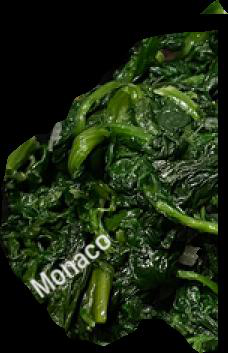

In [119]:
get_image_from_url(urls[3])

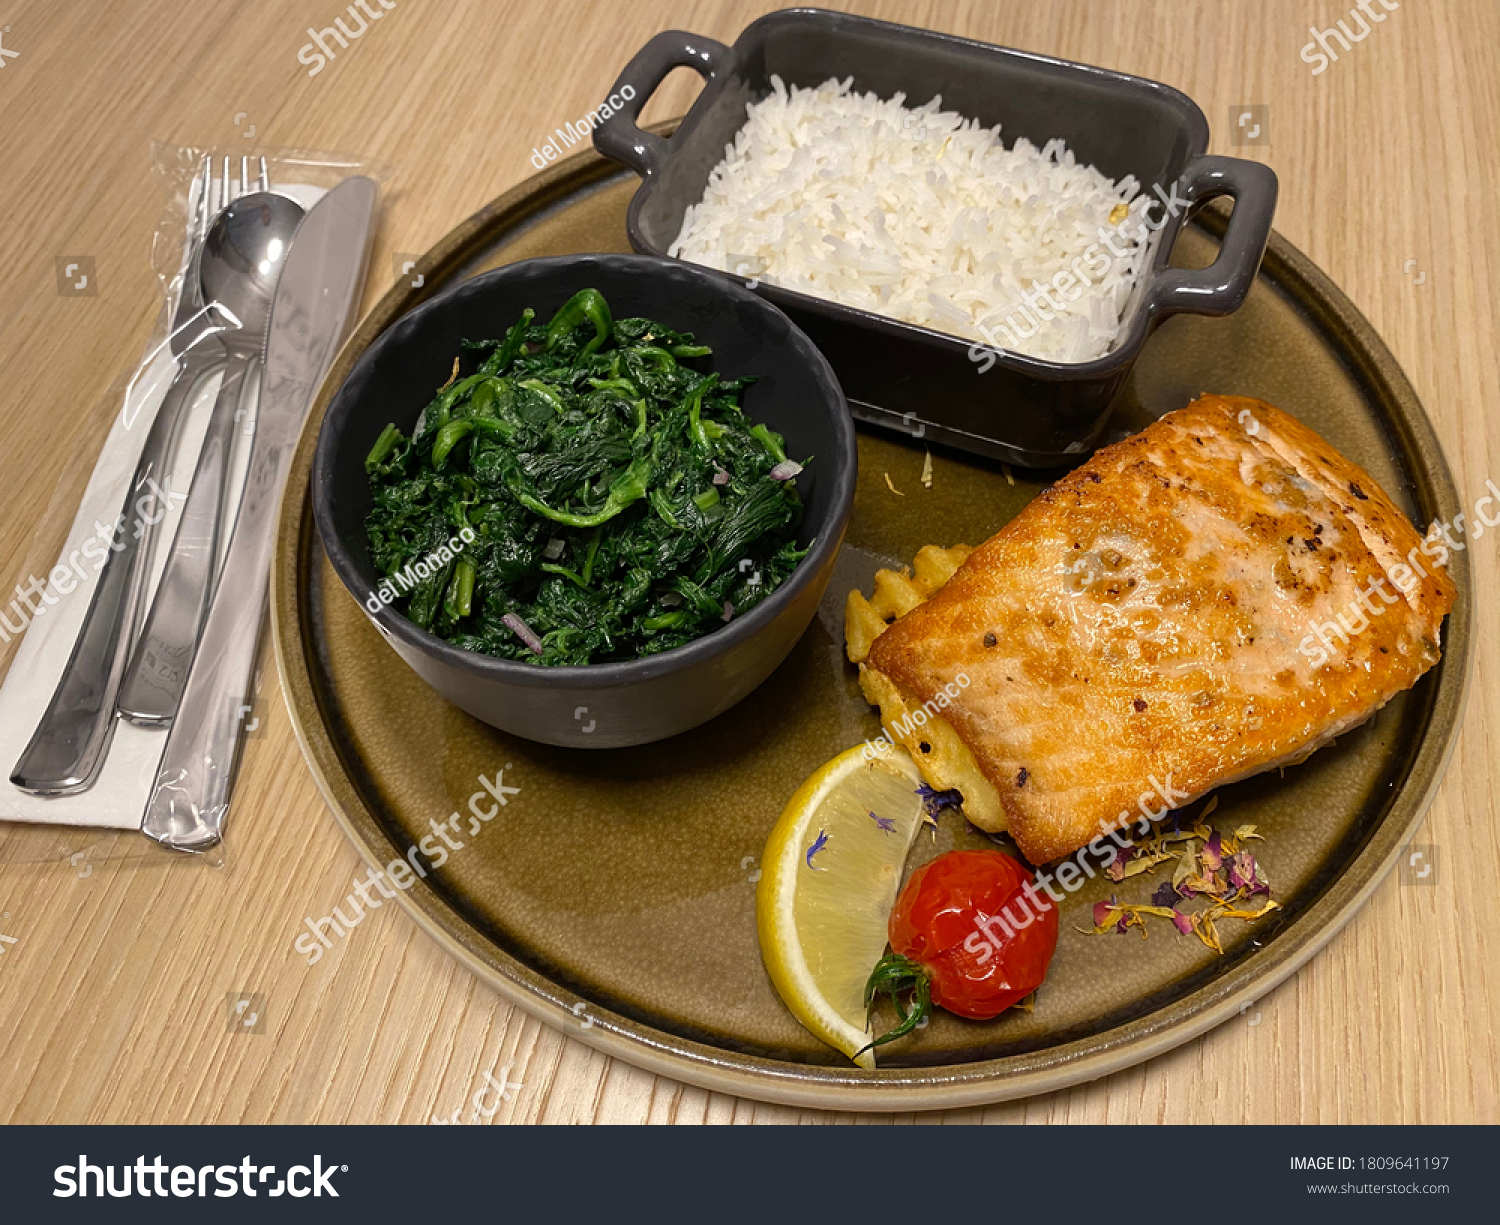

In [117]:
get_image_from_url(url)